This notebook documents the process used for ranking the nodes of each of the road network graph's communities to facilitate the selection of a start and end point of the associated bus route.


In [1]:
import random
import osmnx as ox
import pandas as pd
import networkx as nx
import numpy as np
import route_planning.helpers.route_planning_helper as helper
import config

Load graph and convert edge weights to floats.

In [2]:
G = ox.load_graphml(filepath=f"{config.rp_graphml_path}/communities.graphml")
helper.convert_edge_weights_to_floats(G)

Get Weighted page rank for graph's nodes.

Need to convert MultiDiGraph to standard Graph

In [3]:
pr_graph = nx.Graph(G)
print(f"{type(G)} to {type(pr_graph)}")

<class 'networkx.classes.multidigraph.MultiDiGraph'> to <class 'networkx.classes.graph.Graph'>


In [4]:
pr = nx.pagerank(pr_graph)
pr

{2907242498: 0.0005278720783703455,
 780664835: 0.0002789561526694481,
 1908244498: 0.0001686906427142254,
 3201138706: 0.0003850181600500762,
 3201138713: 0.0003530818666913692,
 1417674781: 0.00020443990694311745,
 3151921209: 0.000148984993682016,
 3112960060: 0.0004167717369368521,
 911999040: 5.786271056207439e-05,
 821231682: 0.00016326173541560894,
 1908244553: 0.00016191592396470338,
 1417674837: 0.0002789633933527866,
 1417674841: 0.00022523187986199291,
 3112960104: 0.00039536964189223995,
 378372206: 0.00036238478591025933,
 378372230: 6.980157962335908e-05,
 2417655943: 0.0002120603274850127,
 1920073869: 0.00012798626283124938,
 911999147: 0.00041588021221990976,
 2417655996: 0.0004424997249542654,
 821231810: 0.0006822318687224918,
 2417656005: 0.00024456019878921415,
 467796168: 0.0002226518329751855,
 798326984: 0.0006673722539220433,
 911999189: 0.00033997903781011584,
 2114650326: 0.0002304475544637878,
 1917681883: 9.677550755023492e-05,
 3063087326: 0.00019062688540

Assign page rank value to main graph

In [5]:
nx.set_node_attributes(G, 0, "rank")
for node in G.nodes:
    G.nodes[node]["rank"] = pr[node]

Convert the graph to GeoDataFrames of nodes and edges.

Then get a list of unique community labels from the nodes dataframe

14 communities to work through to determine bus route start and end nodes.

In [6]:
nodes, edges = ox.graph_to_gdfs(G)
community_labels = list(np.unique(nodes["community"].values))
community_labels

['0', '1', '10', '11', '14', '15', '2', '3', '4', '5', '6', '7', '8', '9']

Split nodes dataframe into a dataframe for each community.

The 15 highest ranked nodes in each community will be found to give a choice of start and end points for each route.

In [7]:
community_nodes = []
for label in community_labels:
    nodes_df = nodes[nodes["community"] == label]
    nodes_df = helper.get_n_highest_ranked_nodes_in_community(nodes_df, 15)
    community_nodes.append(nodes_df)
len(community_nodes)


/home/danny/College/donegal-bus-routes/venv1/lib/python3.8/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


14

Combine community node dataframes.
Edge keys are all set to 0 by default, assign unique number to each.

This is done so that the saved GraphML file can be opened correctly in gephi for inspection later

In [8]:
nodes = pd.concat(community_nodes)
# add longitude/latitude columns (required to display graphml in Gephi properly)
# nodes["latitude"] = nodes["y"]
# nodes["longitude"] = nodes["x"]
edge_keys = [*range(0, len(edges))]
edges["key"] = edge_keys
G = ox.graph_from_gdfs(nodes, edges)
ox.save_graphml(G, filepath=f"{config.rp_graphml_path}/nodes_ranked.graphml")


In [9]:
max_distance_per_community = helper.greatest_distance_between_top_ranked_nodes(G, community_labels)
max_distance_per_community

[{'0': {'u': 262459232, 'v': 258601523, 'dist': 0.20177243066635694}},
 {'1': {'u': 258453962, 'v': 1574232524, 'dist': 0.18970512152690877}},
 {'10': {'u': 1898286788, 'v': 788873005, 'dist': 0.1766085974679583}},
 {'11': {'u': 2113423914, 'v': 258438279, 'dist': 0.17279097830616238}},
 {'14': {'u': 794807698, 'v': 601118054, 'dist': 0.24594386240800975}},
 {'15': {'u': 529572744, 'v': 2108113902, 'dist': 0.2752774123222234}},
 {'2': {'u': 1909072654, 'v': 1369496941, 'dist': 0.20711147222469348}},
 {'3': {'u': 1885743379, 'v': 1892010032, 'dist': 0.28037061337731434}},
 {'4': {'u': 2031126838, 'v': 3816874303, 'dist': 0.427112226504193}},
 {'5': {'u': 504701424, 'v': 795277182, 'dist': 0.7184062061497657}},
 {'6': {'u': 1875818978, 'v': 302148570, 'dist': 0.14957739260309394}},
 {'7': {'u': 1329136103, 'v': 1917593408, 'dist': 0.43689636944159976}},
 {'8': {'u': 529112576, 'v': 3121637055, 'dist': 0.48299765123732114}},
 {'9': {'u': 793594516, 'v': 1879177039, 'dist': 0.1546117948777

In [10]:
u, v = helper.assign_route_start_end_points(G, max_distance_per_community,
                                            n_communities=len(community_labels))

In [11]:
u

[{'y': 55.1165302,
  'x': -7.4601117,
  'osmid': 262459232,
  'community': '0',
  'rank': 0.0006952453004233725,
  'geometry': <shapely.geometry.point.Point at 0x7eff6fb58310>,
  'top_n': 2,
  'route_flag': 1},
 {'y': 55.3439791,
  'x': -7.3173718,
  'osmid': 258453962,
  'community': '1',
  'rank': 0.0007478161903782531,
  'geometry': <shapely.geometry.point.Point at 0x7eff6e87c790>,
  'top_n': 8,
  'route_flag': 1},
 {'y': 55.0341332,
  'x': -7.5878416,
  'osmid': 1898286788,
  'community': '10',
  'rank': 0.0007360907343096448,
  'geometry': <shapely.geometry.point.Point at 0x7eff6d73fa30>,
  'top_n': 5,
  'route_flag': 1},
 {'y': 55.14581,
  'x': -7.4502753,
  'osmid': 2113423914,
  'community': '11',
  'rank': 0.0006140181838969793,
  'geometry': <shapely.geometry.point.Point at 0x7eff6fb7c370>,
  'top_n': 5,
  'route_flag': 1},
 {'y': 55.1257346,
  'x': -7.8694617,
  'osmid': 794807698,
  'community': '14',
  'rank': 0.0006771284060073162,
  'geometry': <shapely.geometry.point.Po

In [12]:
v

[{'y': 55.0781957,
  'x': -7.2620143,
  'osmid': 258601523,
  'community': '0',
  'rank': 0.0006139705257041413,
  'geometry': <shapely.geometry.point.Point at 0x7eff6fa34af0>,
  'top_n': 7,
  'route_flag': 2},
 {'y': 55.2588014,
  'x': -7.1478643,
  'osmid': 1574232524,
  'community': '1',
  'rank': 0.0008153067340908409,
  'geometry': <shapely.geometry.point.Point at 0x7eff6fb7e8b0>,
  'top_n': 4,
  'route_flag': 2},
 {'y': 54.9453778,
  'x': -7.7405278,
  'osmid': 788873005,
  'community': '10',
  'rank': 0.0006238826825071857,
  'highway': 'mini_roundabout',
  'geometry': <shapely.geometry.point.Point at 0x7eff6e86e670>,
  'top_n': 10,
  'route_flag': 2},
 {'y': 55.2769616,
  'x': -7.3377765,
  'osmid': 258438279,
  'community': '11',
  'rank': 0.0005849382994212507,
  'geometry': <shapely.geometry.point.Point at 0x7eff6fa3c0d0>,
  'top_n': 10,
  'route_flag': 2},
 {'y': 55.145993,
  'x': -8.1145698,
  'osmid': 601118054,
  'community': '14',
  'rank': 0.0005048137865957919,
  'geo

In [13]:
ox.save_graphml(G, filepath=f"{config.rp_graphml_path}/route_start_end_flagged.graphml")

In [43]:
nodes, edges = ox.graph_to_gdfs(G)
route_nodes = nodes[(nodes["route_flag"] == 1) | (nodes["route_flag"] == 2)]

route_nodes_graph = ox.graph_from_gdfs(route_nodes, edges)

In [46]:
# convert community labels to integers so that get_node_colors_by_attr can use the community attribute
for x, y in route_nodes_graph.nodes(data=True):
    if "community" in y:
        y["community"] = int(y["community"])

Plot the route start and endpoints, colour based on community

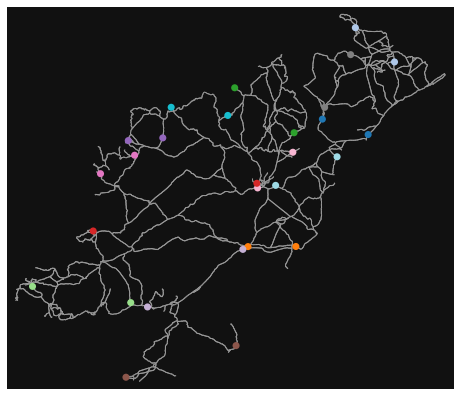

In [52]:
node_colours = ox.plot.get_node_colors_by_attr(route_nodes_graph,
                                               attr="community",
                                               cmap="tab20")

# graph_from_gdfs creates empty nodes so need
# to update node_colours to include those so
# that plot graph function will work correctly
all_nodes = route_nodes_graph.nodes(data=True)

other_nodes = {x: (0, 0, 0, 0) for x, y in G.nodes(data=True) if x not in node_colours.index}
series = pd.Series(other_nodes)
node_colours = node_colours.append(series)

fig, ax = ox.plot_graph(route_nodes_graph, node_color=node_colours, node_size=50)